In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [18]:
key = os.environ.get('AZURE_SEARCH_KEY', 'xxxx')

In [19]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [20]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

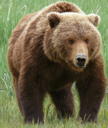

In [21]:
im = Image.open(dest)
im.to_thumb(128,128)

In [4]:
car_types = 'sports car','suv','minivan', 'pickup'
path = Path('cars')

In [23]:
if not path.exists():
    path.mkdir()
    for o in car_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, o)
        download_images(dest, urls=results.attrgot('content_url'))

Run code after this once images are already downloaded:

In [5]:
fns = get_image_files(path)
fns

(#591) [Path('cars/minivan/00000000.jpg'),Path('cars/minivan/00000001.jpg'),Path('cars/minivan/00000002.jpg'),Path('cars/minivan/00000003.jpg'),Path('cars/minivan/00000004.jpg'),Path('cars/minivan/00000005.jpg'),Path('cars/minivan/00000006.jpg'),Path('cars/minivan/00000007.jpg'),Path('cars/minivan/00000008.jpg'),Path('cars/minivan/00000009.jpg')...]

In [6]:
failed = verify_images(fns)
failed

(#0) []

In [7]:
failed.map(Path.unlink);

In [8]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #specifies independent variable is an image and dependent is category
    get_items=get_image_files, #returns all images in the path recursively
    splitter=RandomSplitter(valid_pct=0.2, seed=44), # tp specify training and val datasets
    get_y=parent_label, #parent_label gets the name of the folder a file is in
    item_tfms=Resize(128)) #image transform, in this case making all images uniform

In [13]:
# The above code block gives us a data loader template of sorts
# we still need to specify the actual path to the data (images)
dls = cars.dataloaders(path)

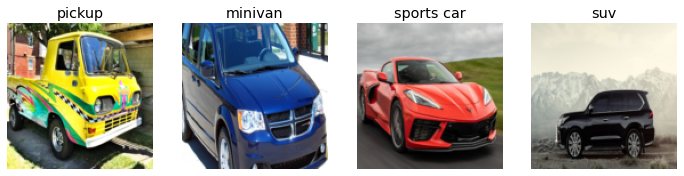

In [14]:
# A dataloader includes training and validation dataloaders
# It is a class that provides few items at a time to a GPU --> by default 64 at a time stacked in a tensor
# The line below shows an example, where it specifies how many to show and what arrangement (grid)
dls.valid.show_batch(max_n=4, nrows=1)

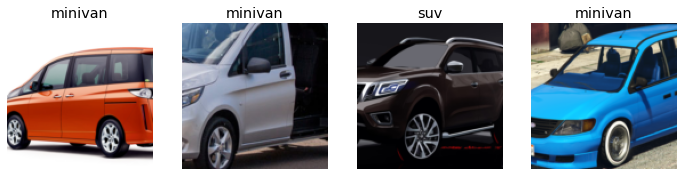

In [15]:
dls.train.show_batch(max_n=4, nrows=1)

By default Resize crops the images to fit a square shape of the size requested, using the full width or height. 
This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

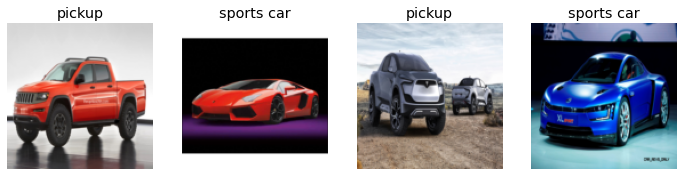

In [21]:
# By default resize, crops an image to make a square shape, keeping either height or width unchanged
# However, with this approach important information can get cut
#cars = cars.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
cars = cars.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cars.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

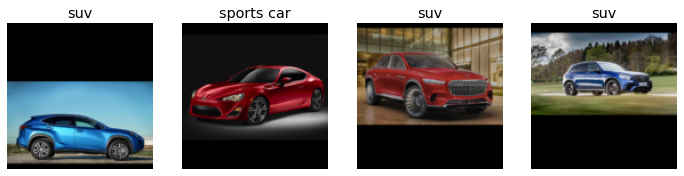

In [23]:
# Alternatively, we can pad the images with 0s 
cars = cars.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cars.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)
# However, with this approach, you are adding more data for the program to process

Both these methods appear wasteful - either leaving out useful info, or changing the shape of an image to make it appear different than reality, or simply adding more data for the program to process. 
Instead, we use a method, where we focus on a random part of the image, and crop the image to select only that part, without distorting it. During each epoch (epoch = one complete pass of the data), we randomly feed a different part of each image


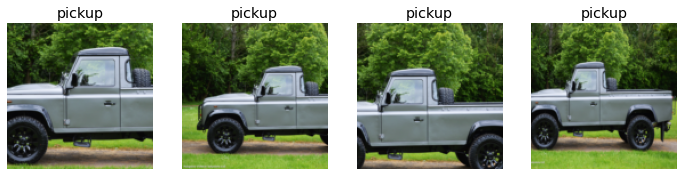

In [25]:
cars = cars.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cars.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Data Augmentation: Examples of common data augmentation techniques - Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.

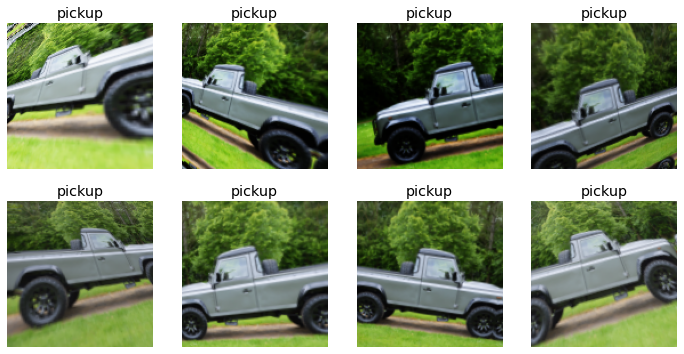

In [26]:
cars = cars.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cars.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Training the model and using it to clean the data:
- Using an image size of 224 pixels, which is standard for computer vision problems
- Applying RandomResizedCrop to feed data during epochs
- Augmenting data by a factor of 2, since we only have 150 images per class

In [30]:
cars = cars.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms(mult=2))
dls = cars.dataloaders(path)

In [51]:
??cnn_learner

We can now create our Learner and fine-tune it in the usual way:

In [53]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.839356,0.965711,0.338983,00:09


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.935474,0.618703,0.220339,00:10
1,0.790214,0.475673,0.186441,00:10
2,0.692697,0.580314,0.177966,00:10
3,0.635236,0.615378,0.161017,00:09
4,0.579208,0.489883,0.144068,00:10
5,0.538977,0.520024,0.152542,00:10
6,0.474518,0.571762,0.118644,00:10
7,0.414086,0.599927,0.152542,00:11
8,0.366244,0.584870,0.127119,00:11
9,0.331204,0.576177,0.135593,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: U

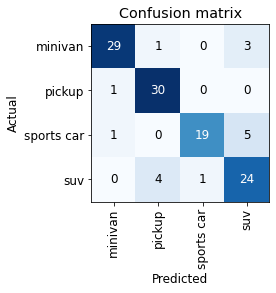

In [54]:
# Confusion matrix to see how the model is perfroming
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

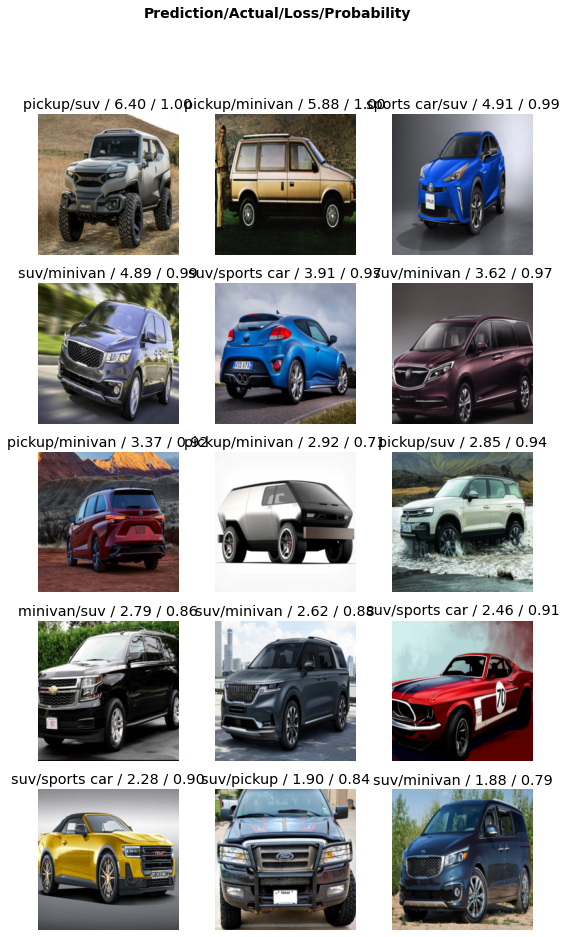

In [49]:
interp.plot_top_losses(20, nrows=5, ncols= 3)

In [25]:
??learn.fine_tune

Cleaning input data manually:

In [43]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [55]:
#hide_output
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [69]:
img = PILImage.create(uploader.data[0])
type_of_car,_,probs = learn.predict(img)
#type_of_car
print(f"What type of car?: {type_of_car}.")
#print(f"Probability it's a sports car: {probs.item():.6f}")

What type of car?: sports car.


In [68]:
learn.pred

tensor([[-2.2194, -1.1583,  4.1221, -5.5035]], device='cuda:0')

In [62]:
type(probs)

torch.Tensor

In [63]:
probs

tensor([1.7495e-03, 5.0552e-03, 9.9313e-01, 6.5562e-05])